In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

def preprocess_data(df, fit_transform=True, preprocessor=None):
    df = df.copy()

    
    df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_")

    
    if "price_2" in df.columns:
        df["price_2"] = df["price_2"].astype(str)

    
    categorical_code_cols = [
        "country",
        "page1_main_category",
        "page2_clothing_model",
        "colour",
        "location",
        "model_photography",
        "price_2"   
    ]
    for col in categorical_code_cols:
        if col in df.columns:
            df[col] = df[col].astype(str)

    
    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    cat_cols = df.select_dtypes(exclude=[np.number]).columns.tolist()

   
    for col in num_cols:
        df[col] = df[col].fillna(df[col].median())
    for col in cat_cols:
        df[col] = df[col].fillna(df[col].mode()[0] if not df[col].mode().empty else "missing")

   
    try:
        onehot = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
    except TypeError:
        onehot = OneHotEncoder(handle_unknown="ignore", sparse=False)

    numeric_transformer = Pipeline(steps=[("scaler", StandardScaler())])
    categorical_transformer = Pipeline(steps=[("onehot", onehot)])

    preprocessor_template = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, num_cols),
            ("cat", categorical_transformer, cat_cols)
        ]
    )

    
    if fit_transform:
        X_transformed = preprocessor_template.fit_transform(df)
        return X_transformed, preprocessor_template, num_cols, cat_cols
    else:
        X_transformed = preprocessor.transform(df)
        return X_transformed, preprocessor, num_cols, cat_cols



In [2]:
train_df = pd.read_csv("p4train.csv")
X_train, preprocessor, num_cols, cat_cols = preprocess_data(train_df, fit_transform=True)

print("Numeric columns:", num_cols)
print("Categorical columns:", cat_cols)


Numeric columns: ['year', 'month', 'day', 'order', 'session_id', 'price', 'page']
Categorical columns: ['country', 'page1_main_category', 'page2_clothing_model', 'colour', 'location', 'model_photography', 'price_2']


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency, f_oneway

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency, f_oneway

def run_eda(df, num_cols, cat_cols):
    
    print("\n Visualizations")

    
    for col in num_cols:
        plt.figure(figsize=(6, 4))
        sns.histplot(df[col], kde=True, bins=30)
        plt.title(f"Histogram of {col}")
        plt.show()

    
    for col in cat_cols:
        plt.figure(figsize=(6, 4))
        df[col].value_counts().plot(kind="bar")
        plt.title(f"Bar chart of {col}")
        plt.show()

   
    if len(num_cols) > 1:
        sns.pairplot(df[num_cols[:4]])  # limit to first 4 numeric columns
        plt.show()

    
    print("\n Session Analysis")
    if "session_id" in df.columns and "page" in df.columns:
        session_summary = df.groupby("session_id").agg(
            session_length=("order", "max"),
            total_pages=("page", "max"),
            unique_main_cats=("page1_main_category", "nunique"),
        ).reset_index()

        print(session_summary.head())

        plt.figure(figsize=(6, 4))
        sns.histplot(session_summary["session_length"], bins=30, kde=True)
        plt.title("Distribution of Session Length")
        plt.show()

    
    print("\n Correlation Analysis")

   
    if len(num_cols) > 1:
        plt.figure(figsize=(8, 6))
        corr = df[num_cols].corr()
        sns.heatmap(corr, annot=True, cmap="coolwarm")
        plt.title("Correlation Heatmap (Numeric Features)")
        plt.show()

    
    print("\n Numeric vs Categorical (ANOVA)")
    for cat in cat_cols:
        for num in num_cols:
            groups = [df[df[cat] == level][num].dropna() for level in df[cat].unique()]
            if len(groups) > 1:
                try:
                    f_stat, p_val = f_oneway(*groups)
                    print(f"ANOVA {num} ~ {cat}: p-value = {p_val:.4f}")
                except:
                    pass

    
    print("\n Categorical vs Categorical (Chi-Square)")
    for i in range(len(cat_cols)):
        for j in range(i + 1, len(cat_cols)):
            table = pd.crosstab(df[cat_cols[i]], df[cat_cols[j]])
            if table.shape[0] > 1 and table.shape[1] > 1:
                chi2, p_val, dof, exp = chi2_contingency(table)
                print(f"Chi-square {cat_cols[i]} vs {cat_cols[j]}: p-value = {p_val:.4f}")

    
    print("\n Time-based Analysis")
    if "year" in df.columns and "month" in df.columns and "day" in df.columns:
        df["date"] = pd.to_datetime(
            df["year"].astype(str) + "-" +
            df["month"].astype(str) + "-" +
            df["day"].astype(str),
            errors="coerce"
        )

        
        df["day_of_week"] = df["date"].dt.day_name()

        plt.figure(figsize=(6, 4))
        sns.countplot(data=df, x="day_of_week", order=[
            "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"
        ])
        plt.title("Visits by Day of Week")
        plt.show()

        
        if "session_id" in df.columns:
            session_duration = df.groupby("session_id")["order"].max()
            plt.figure(figsize=(6, 4))
            sns.histplot(session_duration, bins=30, kde=True)
            plt.title("Distribution of Browsing Duration (Orders per Session)")
            plt.show()


Numeric columns: ['year', 'month', 'day', 'order', 'session_id', 'price', 'page']
Categorical columns: ['country', 'page1_main_category', 'page2_clothing_model', 'colour', 'location', 'model_photography', 'price_2']

 Visualizations


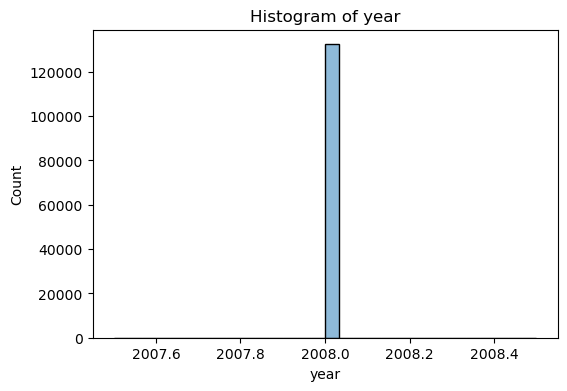

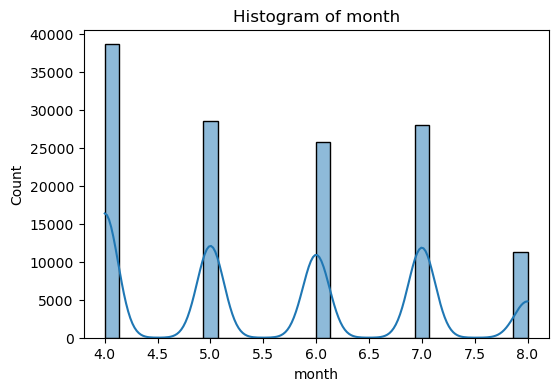

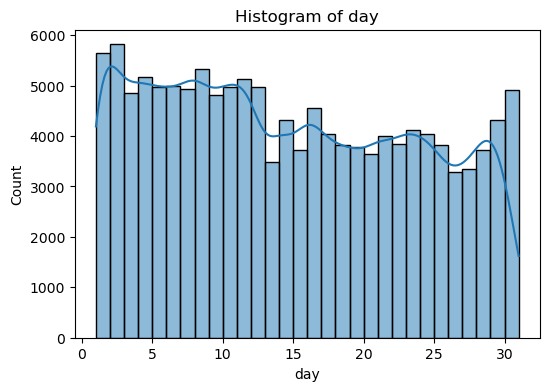

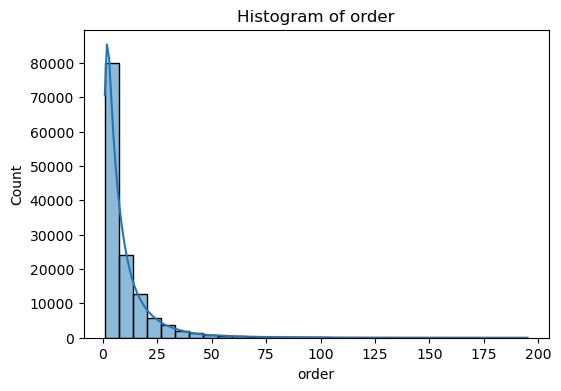

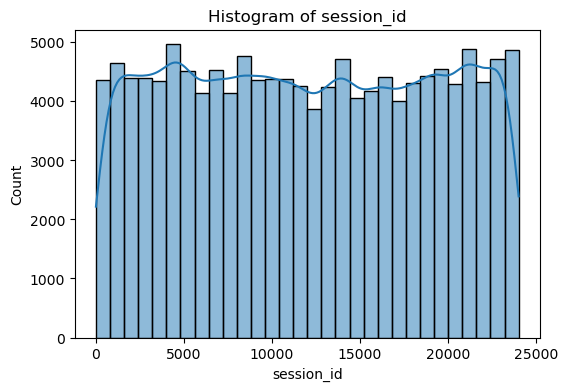

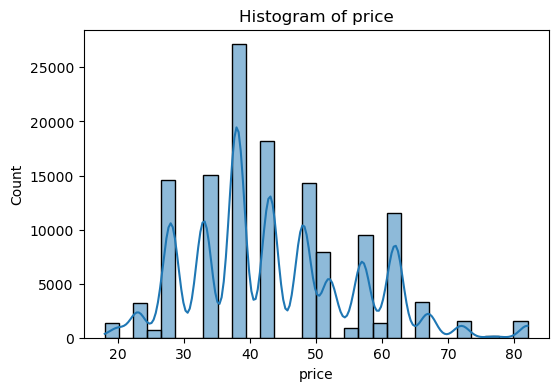

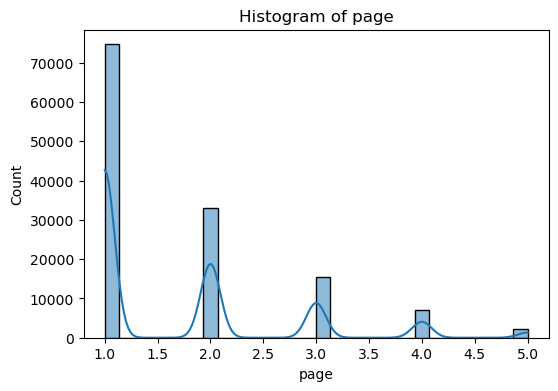

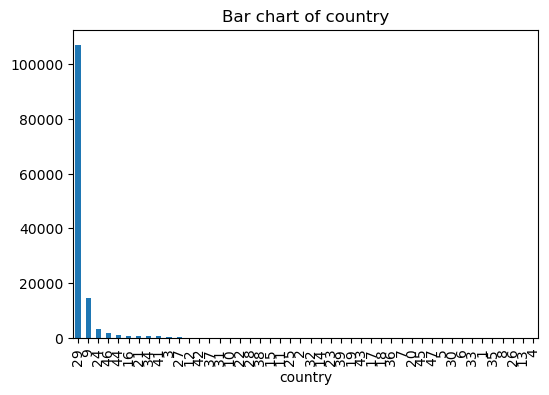

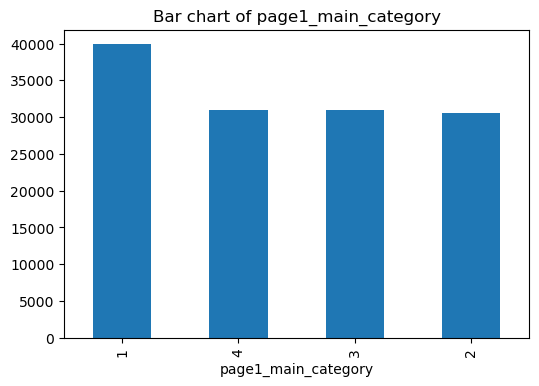

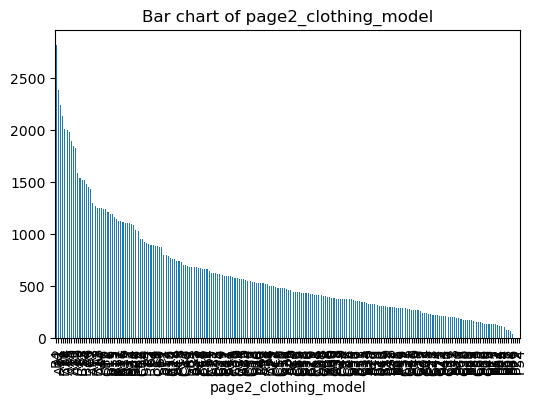

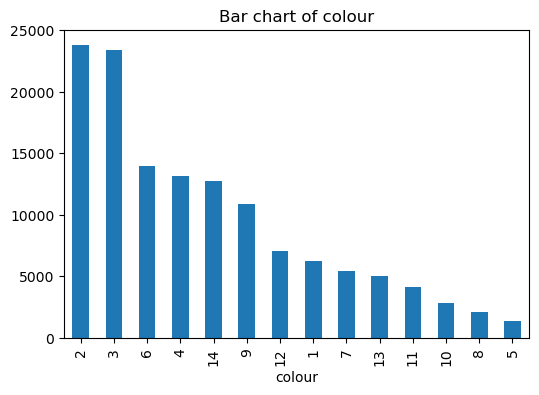

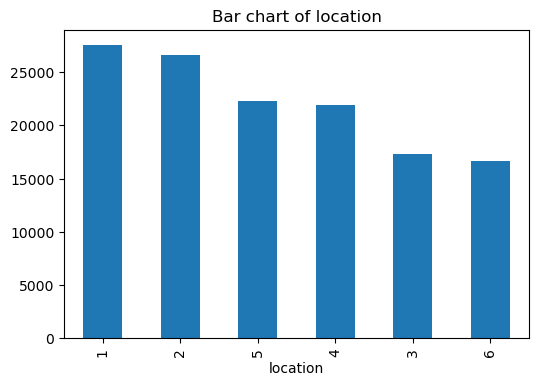

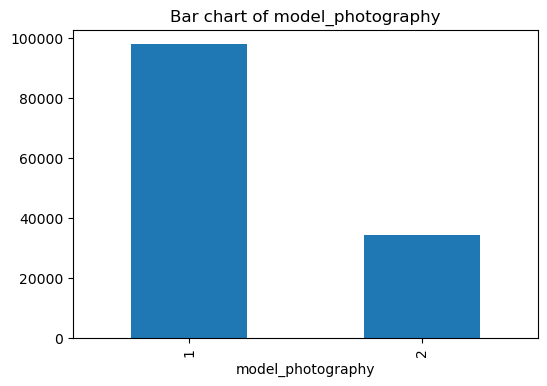

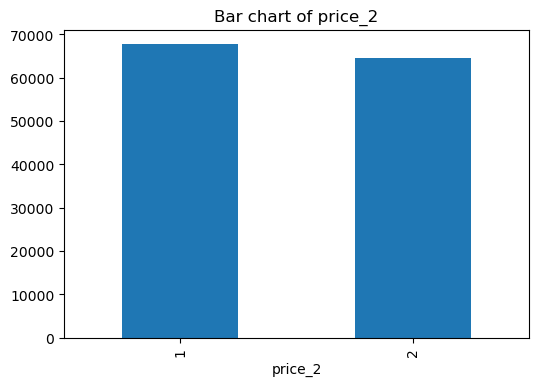

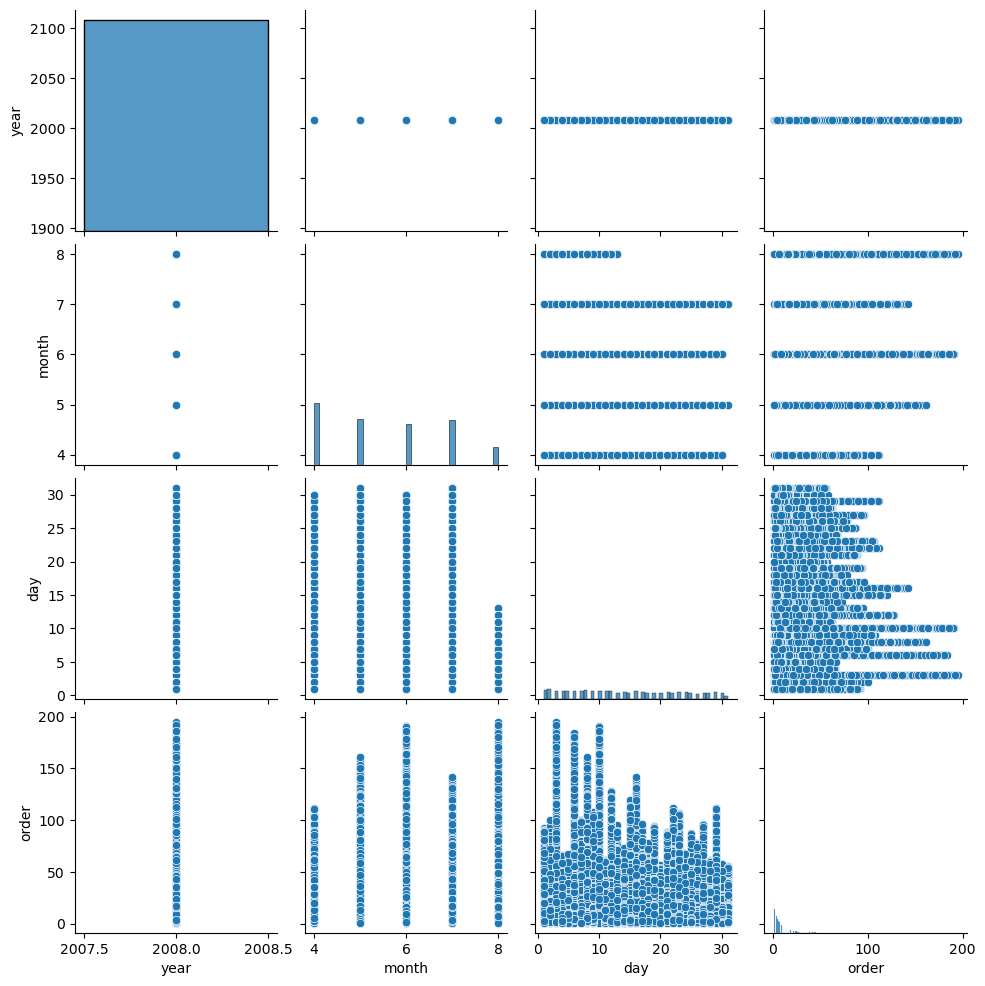


 Session Analysis
   session_id  session_length  total_pages  unique_main_cats
0           1               9            5                 4
1           2              10            2                 3
2           3               5            1                 2
3           4               4            3                 2
4           5               1            2                 1


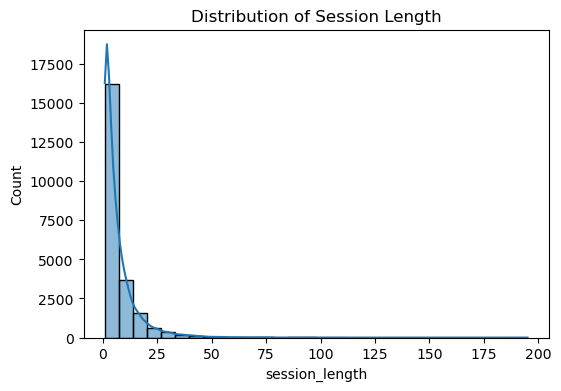


 Correlation Analysis


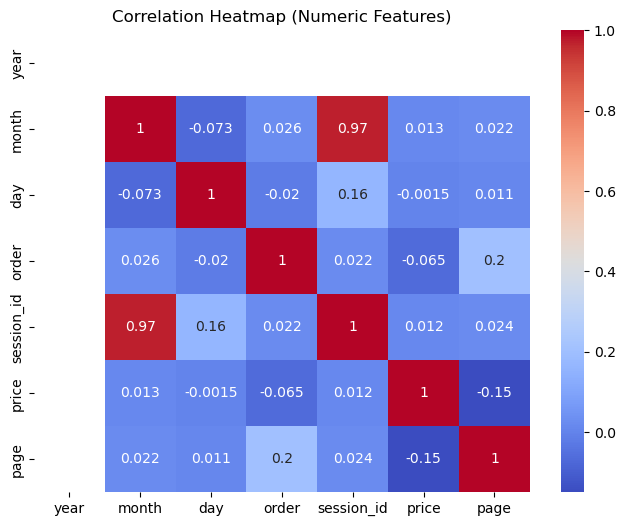


 Numeric vs Categorical (ANOVA)
ANOVA year ~ country: p-value = nan
ANOVA month ~ country: p-value = 0.0000


C:\Users\S.HARSHINI\anaconda3\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: ConstantInputWarning: Each of the input arrays is constant; the F statistic is not defined or infinite
  res = hypotest_fun_out(*samples, **kwds)


ANOVA day ~ country: p-value = 0.0000
ANOVA order ~ country: p-value = 0.0000
ANOVA session_id ~ country: p-value = 0.0000
ANOVA price ~ country: p-value = 0.0000
ANOVA page ~ country: p-value = 0.0000
ANOVA year ~ page1_main_category: p-value = nan
ANOVA month ~ page1_main_category: p-value = 0.0000
ANOVA day ~ page1_main_category: p-value = 0.0632
ANOVA order ~ page1_main_category: p-value = 0.0000
ANOVA session_id ~ page1_main_category: p-value = 0.0000
ANOVA price ~ page1_main_category: p-value = 0.0000
ANOVA page ~ page1_main_category: p-value = 0.0000
ANOVA year ~ page2_clothing_model: p-value = nan
ANOVA month ~ page2_clothing_model: p-value = 0.0000
ANOVA day ~ page2_clothing_model: p-value = 0.0007
ANOVA order ~ page2_clothing_model: p-value = 0.0000
ANOVA session_id ~ page2_clothing_model: p-value = 0.0000
ANOVA price ~ page2_clothing_model: p-value = 0.0000
ANOVA page ~ page2_clothing_model: p-value = 0.0000
ANOVA year ~ colour: p-value = nan
ANOVA month ~ colour: p-value = 

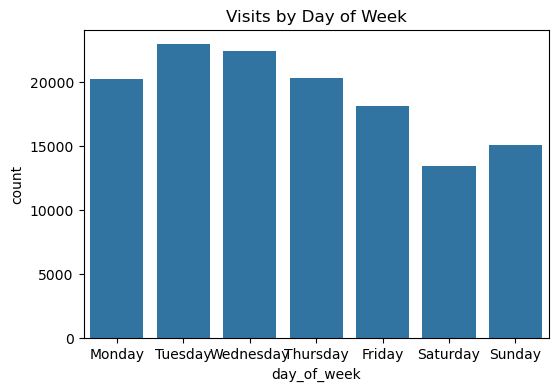

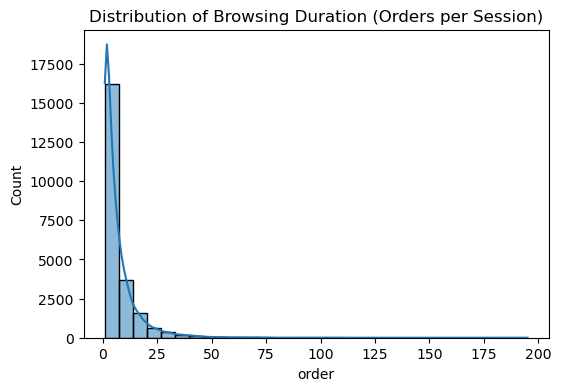

In [5]:

train_df = pd.read_csv("p4train.csv")


X_train, preprocessor, num_cols, cat_cols = preprocess_data(train_df, fit_transform=True)

print("Numeric columns:", num_cols)
print("Categorical columns:", cat_cols)


run_eda(train_df, num_cols, cat_cols)


In [5]:
import pandas as pd
import numpy as np

def feature_engineering(df):
    df = df.copy()

    
    df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_")

   
    session_metrics = df.groupby("session_id").agg(
        session_length=("order", "max"),              
        num_clicks=("order", "count"),               
        unique_categories=("page1_main_category", "nunique"), 
        unique_products=("page2_clothing_model", "nunique")   
    ).reset_index()

    
    
    clickstream = df.groupby("session_id")["page1_main_category"].apply(
        lambda x: "->".join(map(str, x))
    ).reset_index(name="click_sequence")

    
    first_page = df.groupby("session_id")["page1_main_category"].first().reset_index(name="first_category")

   
    last_page = df.groupby("session_id")["page1_main_category"].last().reset_index(name="last_category")

    
    
    session_metrics["is_bounce"] = (session_metrics["num_clicks"] == 1).astype(int)

    
    exit_pages = df.groupby("session_id")["page"].max().reset_index(name="exit_page")

    
    revisit = df["session_id"].value_counts().reset_index()
    revisit.columns = ["session_id", "revisit_count"]

    
    avg_order = df.groupby("session_id")["order"].mean().reset_index(name="avg_order_position")

    continent_map = {
        "Australia": "Oceania",
        "Austria": "Europe", "Belgium": "Europe", "British Virgin Islands": "North America",
        "Cayman Islands": "North America", "Christmas Island": "Oceania", "Croatia": "Europe",
        "Cyprus": "Europe", "Czech Republic": "Europe", "Denmark": "Europe", "Estonia": "Europe",
        "Faroe Islands": "Europe", "Finland": "Europe", "France": "Europe", "Germany": "Europe",
        "Greece": "Europe", "Hungary": "Europe", "Iceland": "Europe", "India": "Asia",
        "Ireland": "Europe", "Italy": "Europe", "Latvia": "Europe", "Lithuania": "Europe",
        "Luxembourg": "Europe", "Mexico": "North America", "Netherlands": "Europe",
        "Norway": "Europe", "Poland": "Europe", "Portugal": "Europe", "Romania": "Europe",
        "Russia": "Europe", "San Marino": "Europe", "Slovakia": "Europe", "Slovenia": "Europe",
        "Spain": "Europe", "Sweden": "Europe", "Switzerland": "Europe", "Ukraine": "Europe",
        "United Arab Emirates": "Asia", "United Kingdom": "Europe", "USA": "North America",
        "biz (.biz)": "Other", "com (.com)": "Other", "int (.int)": "Other", 
        "net (.net)": "Other", "org (*.org)": "Other", "unidentified": "Other"
    }

    if "country" in df.columns:
        df["country"] = df["country"].astype(str)
        df["continent"] = df["country"].map(continent_map).fillna("Other")
        df["is_europe"] = (df["continent"] == "Europe").astype(int)

    
    session_features = (
        session_metrics
        .merge(clickstream, on="session_id", how="left")
        .merge(first_page, on="session_id", how="left")
        .merge(last_page, on="session_id", how="left")
        .merge(exit_pages, on="session_id", how="left")
        .merge(revisit, on="session_id", how="left")
        .merge(avg_order, on="session_id", how="left")
    )

    return df, session_features


In [6]:

train_df = pd.read_csv("p4train.csv")


df_fe, session_features = feature_engineering(train_df)

print("Engineered dataset shape:", df_fe.shape)
print("Session-level features:\n", session_features.head())


Engineered dataset shape: (132379, 16)
Session-level features:
    session_id  session_length  num_clicks  unique_categories  unique_products  \
0           1               9           8                  4                8   
1           2              10           9                  3                8   
2           3               5           3                  2                3   
3           4               4           4                  2                4   
4           5               1           1                  1                1   

   is_bounce             click_sequence  first_category  last_category  \
0          0     2->2->4->4->1->3->2->3               2              3   
1          0  1->4->1->2->2->2->4->4->2               1              2   
2          0                    3->3->2               3              2   
3          0                 1->3->1->3               1              3   
4          1                          3               3              3   

   e

Class distribution for PRICE_2:
price_2
1    0.511516
2    0.488484
Name: proportion, dtype: float64


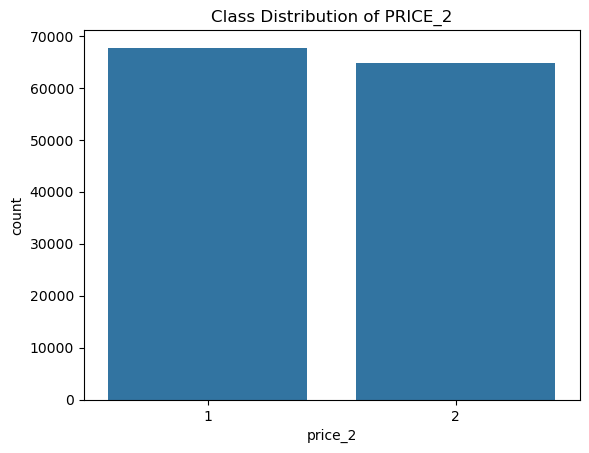

In [7]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


df = pd.read_csv("p4train.csv")


print("Class distribution for PRICE_2:")
print(df["price_2"].value_counts(normalize=True))


sns.countplot(x="price_2", data=df)
plt.title("Class Distribution of PRICE_2")
plt.show()


In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler


df = pd.read_csv("p4train.csv")


X = df.drop(columns=["price_2", "price"])  
y = df["price_2"]


X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)


cat_cols = X_train.select_dtypes(exclude=[np.number]).columns.tolist()
num_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ("num", "passthrough", num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ]
)


X_train_enc = preprocessor.fit_transform(X_train)
X_test_enc = preprocessor.transform(X_test)


smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train_enc, y_train)


under = RandomUnderSampler(random_state=42)
X_train_under, y_train_under = under.fit_resample(X_train_enc, y_train)

print("Original:", y_train.value_counts())
print("After SMOTE:", y_train_sm.value_counts())
print("After Undersampling:", y_train_under.value_counts())


log_reg = LogisticRegression(class_weight="balanced", max_iter=1000, random_state=42)
log_reg.fit(X_train_enc, y_train)
y_pred_lr = log_reg.predict(X_test_enc)
print("\nLogistic Regression (Class Weights):")
print(classification_report(y_test, y_pred_lr))

rf = RandomForestClassifier(class_weight="balanced", random_state=42)
rf.fit(X_train_enc, y_train)
y_pred_rf = rf.predict(X_test_enc)
print("\nRandom Forest (Class Weights):")
print(classification_report(y_test, y_pred_rf))


Original: price_2
1    54171
2    51732
Name: count, dtype: int64
After SMOTE: price_2
1    54171
2    54171
Name: count, dtype: int64
After Undersampling: price_2
1    51732
2    51732
Name: count, dtype: int64


C:\Users\S.HARSHINI\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Logistic Regression (Class Weights):
              precision    recall  f1-score   support

           1       0.73      0.73      0.73     13543
           2       0.72      0.72      0.72     12933

    accuracy                           0.72     26476
   macro avg       0.72      0.72      0.72     26476
weighted avg       0.72      0.72      0.72     26476


Random Forest (Class Weights):
              precision    recall  f1-score   support

           1       1.00      1.00      1.00     13543
           2       1.00      1.00      1.00     12933

    accuracy                           1.00     26476
   macro avg       1.00      1.00      1.00     26476
weighted avg       1.00      1.00      1.00     26476



In [9]:
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingRegressor
import xgboost as xgb


from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    mean_absolute_error, mean_squared_error, r2_score,
    silhouette_score, davies_bouldin_score
)

from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering

In [10]:

train_df = pd.read_csv("p4train.csv")
test_df = pd.read_csv("p4test.csv")


num_cols = ['year', 'month', 'day', 'order', 'session_id', 'price', 'page']
cat_cols = ['country', 'page1_main_category', 'page2_clothing_model',
            'colour', 'location', 'model_photography', 'price_2']


X_train = train_df[num_cols + [col for col in cat_cols if col != "price_2"]].copy()
X_test = test_df[num_cols + [col for col in cat_cols if col != "price_2"]].copy()


y_train_class = train_df["price_2"].map({1: 0, 2: 1})
y_test_class = test_df["price_2"].map({1: 0, 2: 1})
y_train_reg = train_df["price"]
y_test_reg = test_df["price"]


numeric_transformer = Pipeline(steps=[("scaler", StandardScaler())])
categorical_transformer = Pipeline(steps=[("onehot", OneHotEncoder(handle_unknown="ignore"))])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, [c for c in cat_cols if c != "price_2"])
    ]
)


classifiers = {
    "Logistic Regression": LogisticRegression(max_iter=1000, class_weight="balanced"),
    "Decision Tree": DecisionTreeClassifier(class_weight="balanced"),
    "Random Forest": RandomForestClassifier(class_weight="balanced"),
    "XGBoost": xgb.XGBClassifier(eval_metric="logloss", use_label_encoder=False)
}

print("\n Classification Results")
for name, model in classifiers.items():
    pipe = Pipeline(steps=[("preprocessor", preprocessor), ("classifier", model)])
    pipe.fit(X_train, y_train_class)
    y_pred = pipe.predict(X_test)
    y_prob = pipe.predict_proba(X_test)[:, 1] if hasattr(pipe["classifier"], "predict_proba") else None
    
    print(f"\n{name}:")
    print("Accuracy:", accuracy_score(y_test_class, y_pred))
    print("Precision:", precision_score(y_test_class, y_pred, average="weighted"))
    print("Recall:", recall_score(y_test_class, y_pred, average="weighted"))
    print("F1 Score:", f1_score(y_test_class, y_pred, average="weighted"))
    if y_prob is not None:
        print("ROC-AUC:", roc_auc_score(y_test_class, y_prob))


 Classification Results

Logistic Regression:
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
ROC-AUC: 1.0

Decision Tree:
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
ROC-AUC: 1.0

Random Forest:
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
ROC-AUC: 1.0


C:\Users\S.HARSHINI\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:20:41] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



XGBoost:
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
ROC-AUC: 1.0


In [11]:

regressors = {
    "Linear Regression": LinearRegression(),
    "Ridge": Ridge(),
    "Lasso": Lasso(),
    "Gradient Boosting": GradientBoostingRegressor()
}

print("\ Regression Results")
for name, model in regressors.items():
    pipe = Pipeline(steps=[("preprocessor", preprocessor), ("regressor", model)])
    pipe.fit(X_train, y_train_reg)
    y_pred_reg = pipe.predict(X_test)
    
    print(f"\n{name}:")
    print("MAE:", mean_absolute_error(y_test_reg, y_pred_reg))
    print("MSE:", mean_squared_error(y_test_reg, y_pred_reg))
    print("RMSE:", np.sqrt(mean_squared_error(y_test_reg, y_pred_reg)))
    print("R²:", r2_score(y_test_reg, y_pred_reg))

\ Regression Results

Linear Regression:
MAE: 8.362856433792932e-06
MSE: 2.2523731171903553e-09
RMSE: 4.7459173161680294e-05
R²: 0.999999999985774

Ridge:
MAE: 0.00693869664379821
MSE: 0.00010190103491025653
RMSE: 0.010094604247332162
R²: 0.9999993563956645

Lasso:
MAE: 0.8174753440877291
MSE: 1.0069877057826202
RMSE: 1.0034877706193635
R²: 0.9936398913532636

Gradient Boosting:
MAE: 0.00036518363285258
MSE: 3.0738474503777343e-07
RMSE: 0.0005544228936811443
R²: 0.9999999980585658


In [13]:
X_transformed = preprocessor.fit_transform(X_train)
if hasattr(X_transformed, "toarray"):
    X_transformed = X_transformed.toarray()

clustering_models = {
    "KMeans": KMeans(n_clusters=3, random_state=42),
    "DBSCAN": DBSCAN(),
    "Agglomerative": AgglomerativeClustering(n_clusters=3)
}

print("\n Clustering Results ")
for name, model in clustering_models.items():
    try:
        labels = model.fit_predict(X_transformed)
        print(f"\n{name}:")
        unique_labels = set(labels)
        print("Unique cluster labels:", unique_labels)

        if len(unique_labels) > 1:
            valid_idx = labels != -1
            if valid_idx.sum() > 1 and len(set(labels[valid_idx])) > 1:
                print("Silhouette Score:", silhouette_score(X_transformed[valid_idx], labels[valid_idx]))
                print("Davies-Bouldin Index:", davies_bouldin_score(X_transformed[valid_idx], labels[valid_idx]))

        if any(labels >= 0):
            counts = np.bincount(labels[labels >= 0])
            print("Cluster Sizes:", counts)
        else:
            print("No valid clusters found (all noise).")

    except Exception as e:
        print(f"Error with {name}: {e}")


 Clustering Results 

KMeans:
Unique cluster labels: {np.int32(0), np.int32(1), np.int32(2)}
Silhouette Score: 0.13659672601023215
Davies-Bouldin Index: 2.109776126471774
Cluster Sizes: [56925 22673 52781]

DBSCAN:
Unique cluster labels: {np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(15), np.int64(16), np.int64(17), np.int64(18), np.int64(19), np.int64(20), np.int64(21), np.int64(22), np.int64(23), np.int64(24), np.int64(25), np.int64(26), np.int64(27), np.int64(28), np.int64(29), np.int64(30), np.int64(31), np.int64(32), np.int64(33), np.int64(34), np.int64(35), np.int64(36), np.int64(37), np.int64(38), np.int64(39), np.int64(40), np.int64(41), np.int64(42), np.int64(43), np.int64(44), np.int64(45), np.int64(46), np.int64(47), np.int64(48), np.int64(49), np.int64(50), np.int64(51), np.int64(52), np.int64(53), np.int64(54), 